In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar 

--2022-02-14 16:10:32--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  31.1MB/s    in 1.6s    

2022-02-14 16:10:34 (31.1 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
!pip install navec
!pip install pyaspeller

     |████████████████████████████████| 63 kB 2.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install slovnet

In [ ]:
import pandas as pd

import numpy as np
import sklearn

In [ ]:
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec

from navec import Navec

In [ ]:
import torch
from slovnet.model.emb import NavecEmbedding

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def clear_text(text: str):
  bad_symbols = [",", "!", ":", "/", ".", "|", "(", ")", "-", "_", "?",";"]
  clear_text = ''

  for symbol in text:
    if symbol not in bad_symbols:
      clear_text += symbol
  return clear_text

In [ ]:
def add_zero_indexes(ind, max_text_ind_len):
    if len(ind) < max_text_ind_len:
        z_arr = np.zeros((max_text_ind_len - len(ind)),dtype=np.int64).T
        ind = np.concatenate((ind,z_arr),axis=0)
    return ind

In [ ]:
def bin2classes(x:int):
    return np.array([0,1]) if x == 1 else np.array([1,0])
def classes2bin(x):
    return 0 if x == [1,0] else 1

In [ ]:
def get_text_indexes(words: str, word_model):
    indexes = []

    for word in words:
        try:
          indexes.append(word_model.vocab[word])
        except KeyError:
          indexes.append(0)

    return np.array(indexes, dtype=np.int64)

In [ ]:
model = Navec.load("navec_hudlit_v1_12B_500K_300d_100q.tar")

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Datasets/ToxicComments/labeled.csv")

In [ ]:
tokenizer = WordPunctTokenizer()

In [ ]:
train_data

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [ ]:
train_data = train_data.sort_values(by=["comment"], key=lambda x: x.str.len())

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Datasets/ToxicComments/labeled.csv")

In [ ]:
train_data["comment"] = train_data["comment"].apply(lambda x: tokenizer.tokenize(x.lower()))

In [ ]:
#train_data["toxic"] = train_data["toxic"].apply(lambda x: bin2classes(x))

In [ ]:
train_data

,comment,toxic
1595,Я бы Тармашева забрал,0.0
1893,Бауманка астанавитесь,0.0
1737,ПАПИЧ ЛУЧШИЙ НА ТРИПЛ,1.0
1388,Малышь (подвегаеться),0.0
1855,Не читай так больше)),0.0
...,...,...
13688,Агентство DARPA в 2020 году планирует начать р...,0.0
1953,"В Киеве на вокзале Мен було рок в 19, коли мен...",1.0
5795,С 19 апреля в Николаеве будет действовать запр...,0.0
3016,"Блеаадь, как же обидно когда создаешь тред, па...",1.0


In [ ]:
train_data['indexed_text'] = train_data['comment'].apply(lambda x: get_text_indexes(x,model))

In [ ]:
train_data.head()

,comment,toxic,indexed_text
1595,"[я, бы, тармашева, забрал]",0.0,"[497765, 50423, 0, 126272]"
1893,"[бауманка, астанавитесь]",0.0,"[0, 0]"
1737,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0]"
1388,"[малышь, (, подвегаеться, )]",0.0,"[0, 0, 0, 0]"
1855,"[не, читай, так, больше, ))]",0.0,"[236483, 481511, 428858, 43995, 0]"


In [ ]:
train_data['indexed_text_len'] = train_data['indexed_text'].apply(lambda x: len(x))

In [ ]:
train_data

,comment,toxic,indexed_text,indexed_text_len
1595,"[я, бы, тармашева, забрал]",0.0,"[497765, 50423, 0, 126272]",4
1893,"[бауманка, астанавитесь]",0.0,"[0, 0]",2
1737,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0]",4
1388,"[малышь, (, подвегаеться, )]",0.0,"[0, 0, 0, 0]",4
1855,"[не, читай, так, больше, ))]",0.0,"[236483, 481511, 428858, 43995, 0]",5
...,...,...,...,...
13688,"[агентство, darpa, в, 2020, году, планирует, н...",0.0,"[16206, 3016, 51199, 0, 91885, 300229, 235924,...",716
1953,"[в, киеве, на, вокзале, мен, було, рок, в, 19,...",1.0,"[51199, 169208, 225007, 67265, 211842, 49031, ...",1207
5795,"[с, 19, апреля, в, николаеве, будет, действова...",0.0,"[383451, 0, 24273, 51199, 249193, 48454, 10389...",882
3016,"[блеаадь, ,, как, же, обидно, когда, создаешь,...",1.0,"[0, 0, 161623, 122803, 254781, 173619, 408931,...",970


In [ ]:
train_data = train_data.iloc[:-20]

In [ ]:
train_data

,comment,toxic,indexed_text,indexed_text_len
1595,"[я, бы, тармашева, забрал]",0.0,"[497765, 50423, 0, 126272]",4
1893,"[бауманка, астанавитесь]",0.0,"[0, 0]",2
1737,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0]",4
1388,"[малышь, (, подвегаеться, )]",0.0,"[0, 0, 0, 0]",4
1855,"[не, читай, так, больше, ))]",0.0,"[236483, 481511, 428858, 43995, 0]",5
...,...,...,...,...
303,"[нглийские, ученые, из, центра, исследований, ...",0.0,"[0, 459529, 147875, 476225, 158050, 389729, 0,...",415
77,"[число, проституток, в, израиле, продолжает, р...",0.0,"[481291, 351523, 51199, 150835, 346251, 370974...",491
35,"[возьмём, как, пример, россию, ,, западноевроп...",0.0,"[67022, 161623, 339099, 380170, 0, 135081, 421...",515
14164,"[совместная, российско, -, американская, мисси...",0.0,"[407766, 0, 0, 20927, 216442, 55713, 0, 99732,...",476


In [ ]:
max_len = train_data['indexed_text_len'].max()
max_len

524

In [ ]:
train_data["indexed_text"] = train_data["indexed_text"].apply(lambda x: add_zero_indexes(x, max_len))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_data

,comment,toxic,indexed_text,indexed_text_len
1595,"[я, бы, тармашева, забрал]",0.0,"[497765, 50423, 0, 126272, 0, 0, 0, 0, 0, 0, 0...",4
1893,"[бауманка, астанавитесь]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
1737,"[папич, лучший, на, трипл]",1.0,"[0, 201294, 225007, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
1388,"[малышь, (, подвегаеться, )]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
1855,"[не, читай, так, больше, ))]",0.0,"[236483, 481511, 428858, 43995, 0, 0, 0, 0, 0,...",5
...,...,...,...,...
303,"[нглийские, ученые, из, центра, исследований, ...",0.0,"[0, 459529, 147875, 476225, 158050, 389729, 0,...",415
77,"[число, проституток, в, израиле, продолжает, р...",0.0,"[481291, 351523, 51199, 150835, 346251, 370974...",491
35,"[возьмём, как, пример, россию, ,, западноевроп...",0.0,"[67022, 161623, 339099, 380170, 0, 135081, 421...",515
14164,"[совместная, российско, -, американская, мисси...",0.0,"[407766, 0, 0, 20927, 216442, 55713, 0, 99732,...",476


In [ ]:
X = train_data['indexed_text'].to_list()

In [ ]:
y = train_data["toxic"].to_list()

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.02, random_state=42)

In [ ]:
X = []

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [ ]:
class TextClassifierNN(torch.nn.Module):

    def __init__(self, embedding_dim, gru_hidden_size, output_size, navec):
        super(TextClassifierNN, self).__init__()

        self.relu = torch.nn.ReLU()

        self.softmax = torch.nn.Softmax()

        self.dropout = torch.nn.Dropout(0.15)

        self.embedding = NavecEmbedding(navec) #torch.nn.Embedding(input_size, embedding_dim)

        self.conv1 = torch.nn.Conv1d(300, 512, kernel_size=5,padding=2)
        self.conv2 = torch.nn.Conv1d(512, 1024, kernel_size=3,padding=1)
        self.conv3 = torch.nn.Conv1d(1024, 2048, kernel_size=5,padding=2)

        self.gru = torch.nn.GRU(2048, gru_hidden_size, batch_first = True, num_layers=2)

        self.fc1 = torch.nn.Linear(gru_hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)

        x = x.permute((0,2,1))

        x = self.conv1(x)

        x = self.relu(x)

        x = self.conv2(x)

        x = self.relu(x)

        x = self.conv3(x)

        x = self.relu(x)

        x = self.dropout(x)

        x = x.permute((0,2,1))

        x = self.gru(x)[0].mean(dim=1) # (batch_size, L, hidden_size)

        x = self.fc1(x)
        
        return x

    def predict(self,x):
        return self.softmax(self.forward(x))


In [ ]:
Net = TextClassifierNN(300, 512, 256, 2, model)
Net.to(device)

loss = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(Net.parameters(), lr=1.0e-3)

In [ ]:
test_loss_history = []
test_accuracy_history = []
test_precision_history = []

In [ ]:
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

X_test = torch.LongTensor(X_test)
y_test = torch.LongTensor(y_test)

In [ ]:
X_test = X_test#.to(device)
y_test = y_test#.to(device)

In [ ]:
Net.train()

batch_size = 150

for epoch in range(5):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        with torch.no_grad():
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]#.to(device)
            y_batch = y_train[batch_indexes]#.to(device)
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

        preds = Net.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
      test_preds = Net.forward(X_test.cuda()).cpu()

      loss_test_value = loss(test_preds, y_test).detach().data.cpu()


      test_loss_history.append(loss_test_value)
      
      accuracy = (test_preds.argmax(dim=1) == y_test).detach().float().mean().data.cpu()
      test_accuracy_history.append(accuracy)
      
      precision = sklearn.metrics.precision_score(test_preds.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
      test_precision_history.append(precision)

      print(f"epoch {epoch+1}; test loss {loss_test_value}; test accuracy {accuracy}; test precision {precision}")
torch.save(Net.state_dict(),"/content/drive/MyDrive/Colab Notebooks/TextClassifierNN.nn")

epoch 1; test loss 0.6172476410865784; test accuracy 0.6944444179534912; test precision 0.0
epoch 2; test loss 0.624207615852356; test accuracy 0.6944444179534912; test precision 0.0
epoch 3; test loss 0.622703492641449; test accuracy 0.6944444179534912; test precision 0.0
epoch 4; test loss 0.6155379414558411; test accuracy 0.6944444179534912; test precision 0.0
epoch 5; test loss 0.6225975155830383; test accuracy 0.6944444179534912; test precision 0.0


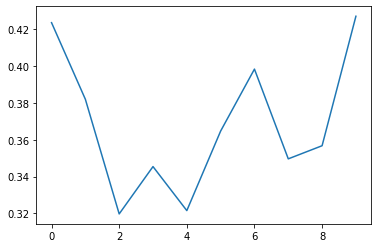

In [ ]:
plt.plot(test_loss_history, label='loss')

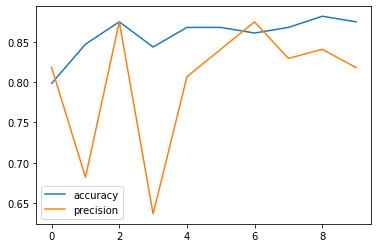

In [ ]:
plt.plot(test_accuracy_history, label='accuracy')
plt.plot(test_precision_history, label='precision')
plt.legend()
plt.show()  

In [ ]:
with torch.no_grad():
    y_pred = Net.forward(X_test)

In [ ]:
precision = sklearn.metrics.precision_score(y_pred.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
precision

0.8181818181818182

In [ ]:
recall = sklearn.metrics.recall_score(y_pred.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
recall

0.7741935483870968

In [ ]:
!nvidia-smi

Wed Oct 13 11:58:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0   124W / 149W |   9531MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------